In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import math

In [2]:
def ExactSolution(x,y):
    # e^{-x}(x+y^3)
    return torch.exp(-x)*(x+y.pow(3))

In [3]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1])
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1)
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

C:\Users\RyanPC\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[0.1250, 0.1250],
        [0.1250, 0.2500],
        [0.1250, 0.3750],
        [0.1250, 0.5000],
        [0.1250, 0.6250],
        [0.1250, 0.7500],
        [0.1250, 0.8750],
        [0.2500, 0.1250],
        [0.2500, 0.2500],
        [0.2500, 0.3750],
        [0.2500, 0.5000],
        [0.2500, 0.6250],
        [0.2500, 0.7500],
        [0.2500, 0.8750],
        [0.3750, 0.1250],
        [0.3750, 0.2500],
        [0.3750, 0.3750],
        [0.3750, 0.5000],
        [0.3750, 0.6250],
        [0.3750, 0.7500],
        [0.3750, 0.8750],
        [0.5000, 0.1250],
        [0.5000, 0.2500],
        [0.5000, 0.3750],
        [0.5000, 0.5000],
        [0.5000, 0.6250],
        [0.5000, 0.7500],
        [0.5000, 0.8750],
        [0.6250, 0.1250],
        [0.6250, 0.2500],
        [0.6250, 0.3750],
        [0.6250, 0.5000],
        [0.6250, 0.6250],
        [0.6250, 0.7500],
        [0.6250, 0.8750],
        [0.7500, 0.1250],
        [0.7500, 0.2500],
        [0.7500, 0.3750],
        [0.7

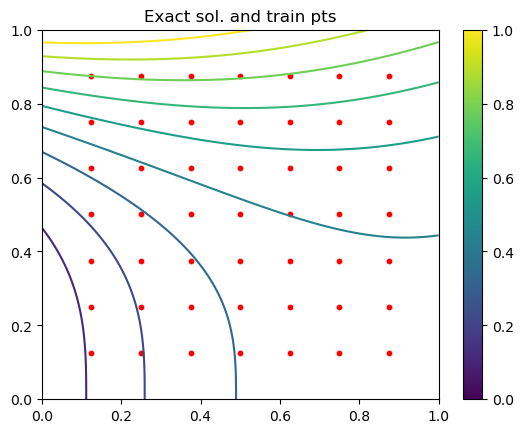

In [4]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, train_data = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.scatter(train_data[:,0],train_data[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

train_data.requires_grad_(True)

In [5]:
# x = np.linspace(0,1,100)
# y = np.linspace(0,1,100)
# x_train, y_train = np.meshgrid(x,y)
# train_data = torch.tensor(np.hstack((x_train.ravel()[:,None],y_train.ravel()[:,None])),\
#                          dtype = torch.float32)
# train_data.requires_grad_(True)

In [6]:
class NN(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # 1st hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
        
        
    def forward(self, xb):
        act = nn.Tanh()
#         act = torch.sigmoid()
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = torch.sigmoid(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

def SolutionModel(x,y,NN):
    # u(x,y) = A(x,y) + x(1-x)y(1-y)NN(x,y;w), where
    # A(x,y) = (1-x)y^3 + x(1+y^3)e^{-1} + (1-y)x(e^{-x}-e^{-1}) + y[(1+x)e^{-x}-(1-x+2xe^{-1})]
    em1 = torch.tensor(np.exp(-1.0))
    emx = torch.exp(-x)
    A1 = (1-x)*y.pow(3)
    A2 = x*(1+y.pow(3))*em1
    A3 = (1-y)*x*(emx-em1)
    A4 = y*((1+x)*emx-(1-x+2*x*em1))
    A = A1+A2+A3+A4
    B = x*(1-x)*y*(1-y)
    sol = A[:,None]+B[:,None]*NN
    return sol
def Solution(x,y,NN):
    # u(x,y) = A(x,y) + x(1-x)y(1-y)NN(x,y;w), where
    # A(x,y) = (1-x)y^3 + x(1+y^3)e^{-1} + (1-y)x(e^{-x}-e^{-1}) + y[(1+x)e^{-x}-(1-x+2xe^{-1})]
    em1 = torch.tensor(np.exp(-1.0))
    emx = torch.exp(-x)
    A1 = (1-x)*y.pow(3)
    A2 = x*(1+y.pow(3))*em1
    A3 = (1-y)*x*(emx-em1)
    A4 = y*((1+x)*emx-(1-x+2*x*em1))
    A = A1+A2+A3+A4
    B = x*(1-x)*y*(1-y)
    sol = A+B*NN
    return sol

def RHS(x,y):
    return torch.exp(-x)*(x-2+y.pow(3)+6*y)


In [7]:
N_neuron = 10
input_size = 2
output_size = 1

model = NN(input_size,N_neuron,output_size)

In [8]:
#prepare training data
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [10]:
for epoch in range(2000):
    TOL = 1.0e-8
    for X,y in train_dl:
        optimizer.zero_grad()
        nn_approx = model(X)
        Q = SolutionModel(X[:,0],X[:,1],nn_approx)
        
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), create_graph=True)
        dQ = derivQ[0]
        
        deriv_xx_xy = torch.autograd.grad(dQ[:,0], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,0]), \
        retain_graph=True, create_graph=True)
        
        deriv_yx_yy = torch.autograd.grad(dQ[:,1], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,1]), \
        retain_graph=True, create_graph=True)
        
        Qyy = deriv_yx_yy[0][:,1]
        Qxx = deriv_xx_xy[0][:,0]
        
        lhs = Qxx+Qyy - RHS(X[:,0],X[:,1])
        
        loss = loss_fn(lhs,y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 1:
        print('loss at epoch {} is {}'.format(epoch,loss))
    if loss < TOL:
        break
        print('done')

loss at epoch 1 is 0.00014291149273049086
loss at epoch 101 is 0.00012730190064758062
loss at epoch 201 is 0.00011025405547115952
loss at epoch 301 is 9.199278429150581e-05
loss at epoch 401 is 7.31769177946262e-05
loss at epoch 501 is 5.501614577951841e-05
loss at epoch 601 is 3.904719778802246e-05
loss at epoch 701 is 2.652636612765491e-05
loss at epoch 801 is 1.7856933482107706e-05
loss at epoch 901 is 1.2518430594354868e-05
loss at epoch 1001 is 9.514646990282927e-06
loss at epoch 1101 is 7.891275345173199e-06
loss at epoch 1201 is 6.988266250118613e-06
loss at epoch 1301 is 6.435049726860598e-06
loss at epoch 1401 is 6.051441687304759e-06
loss at epoch 1501 is 5.753745426773094e-06
loss at epoch 1601 is 5.50416370970197e-06
loss at epoch 1701 is 5.283526206767419e-06
loss at epoch 1801 is 5.081918516225414e-06
loss at epoch 1901 is 4.893014192930423e-06


Max error =  4.339218e-05
Mean error =  1.2398315e-05
RMS error =  1.5807382e-05


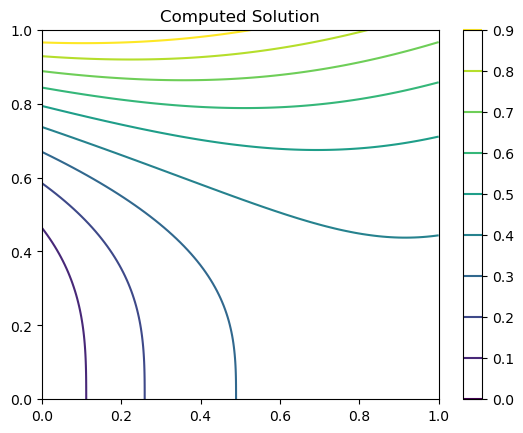

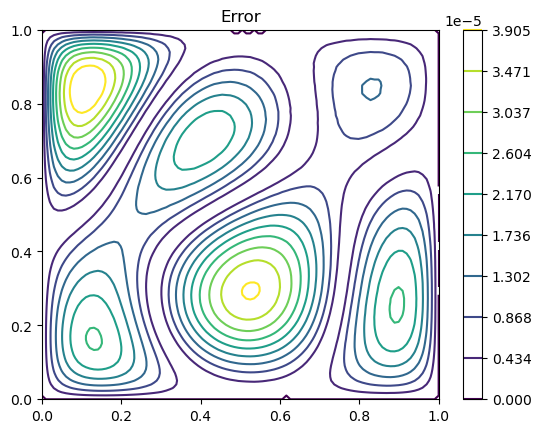

In [12]:
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        pt = torch.tensor([[xtest_grid[i,j],ytest_grid[i,j]]])
        sol_test[i,j] = Solution(xtest_grid[i,j],ytest_grid[i,j],model(pt))
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test.detach().numpy(),torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact).detach().numpy()
error_vector = np.reshape(error,(Ntest,1))
error_max = np.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,np.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",np.max(error_vector))
print("Mean error = ",np.mean(error_vector))
print("RMS error = ",np.sqrt(np.mean(error_vector**2)))